# Exploratory data analysis of the data from multiple cancer patients

---

In this notebook we will analyze PBMC data set from multiple cancer patients at 3 different time points before, during and after the proton therapy treatment. The treatment takes approximately 6 weeks with multiple sessions.

At each time point 10ml blood were taken and the PBMCs were purifried, stained with DAPI, gH2AX and Lamin A/C and imaged with 16bit at a resolution of 0.09 micron in x-y direction, respectively 0.5 micron in z-direction. Each FoV is of the size of (1024x1024x40) pixels.

The data will be compared with a control data set of PBMCs purified from blood of 10 healthy volunteers of varying sex and age (24-60). In this analyses we will use features extracted that describe the nuclear morphology and chromatin organization in 2D/3D and the gH2AX and Lamin A/C expression.

---

## 0. Environmental setup

First, we load the required libraries and define functions, that we will use later on for the analyses.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannot import add_stat_annotation
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import sys
import cv2 as cv

sys.path.append("../../../../..")
from src.utils.notebooks.eda import *

seed = 1234
random.seed(1234)
np.random.seed(1234)

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the data sets that describe the PBMC population of the healthy controls as well as of patient 11 at the different time points over the course of the treatment.

In [3]:
hv_root_data_dir = "../../../../../data/pbmc_hv/proteins/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [4]:
hv_data = read_in_protein_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]

Load data: 100%|██████████| 10/10 [00:00<00:00, 40.02it/s]


<IPython.core.display.Javascript object>

In [5]:
hv_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,rel_lamin_3d_int,min_lamin_3d_int,max_lamin_3d_int,mean_lamin_3d_int,std_lamin_3d_int,q25_lamin_3d_int,q75_lamin_3d_int,median_lamin_3d_int,kurtosis_lamin_3d_int,skewness_lamin_3d_int
count,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,...,2531.000000,2531.0,2531.000000,2531.000000,2531.000000,2531.0,2531.000000,2531.000000,2531.000000,2531.000000
mean,4.340182,58.661004,72.431055,0.812678,24.712586,36.848060,31.767277,31.548947,24.833063,29.437776,...,1700.487742,0.0,16683.073489,1700.487742,1915.245690,0.0,317.884433,1012.849467,37.091881,5.085724
std,2.825778,5.683314,6.017390,0.078606,3.724564,3.272279,2.357691,2.277423,3.774589,2.583662,...,3827.356936,0.0,15244.372878,3827.356936,3000.087935,0.0,973.788409,3202.733199,16.610720,1.034679
min,1.000000,28.000000,38.000000,0.401869,0.365230,18.751232,15.292438,13.878844,0.805253,10.900053,...,64.243603,0.0,4462.000000,64.243603,216.980575,0.0,24.000000,0.000000,0.922634,1.558049
25%,2.000000,55.000000,69.000000,0.767123,22.690063,34.852685,30.479400,30.290000,22.719958,27.994274,...,311.811906,0.0,7696.500000,311.811906,629.480164,0.0,75.500000,42.000000,25.692168,4.369181
50%,4.000000,59.000000,72.000000,0.826087,25.200838,36.465208,31.711524,31.567897,25.245313,29.596131,...,464.971623,0.0,9690.000000,464.971623,804.252350,0.0,92.000000,73.000000,35.045603,5.053400
75%,6.000000,63.000000,75.000000,0.871429,27.309329,38.391488,33.113875,32.809059,27.409410,31.120294,...,1147.226395,0.0,19137.500000,1147.226395,1755.696268,0.0,148.000000,254.000000,45.611245,5.752630
max,22.000000,76.000000,119.000000,0.970588,33.045294,63.028342,40.760103,40.094553,36.742734,36.552356,...,44695.651397,0.0,65535.000000,44695.651397,23595.542877,0.0,17117.750000,52653.000000,172.027058,9.710147


<IPython.core.display.Javascript object>

In [77]:
tp1_root_data_dir = "../../../../../data/pbmc_pt/proteins/timepoint_1/"

tp1_features = read_in_protein_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)


cancer_data = tp1_features
cancer_data["id"] = cancer_data["sample"] + cancer_data["timepoint"]

cancer_data = cancer_data.loc[
    ~cancer_data.loc[:, "sample"].isin(["p22", "p24", "p25", "p29"])
]

cancer_data = cancer_data.loc[cancer_data.id != "p212"]
cancer_data.loc[:, "timepoint"] = cancer_data.loc[:, "timepoint"].map(
    {"ctrl": "ctrl", "1": "pre-treatment"}
)

Load data: 100%|██████████| 15/15 [00:00<00:00, 34.00it/s]


<IPython.core.display.Javascript object>

In [78]:
np.unique(cancer_data.loc[:, "sample"])

array(['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19',
       'p20', 'p21'], dtype=object)

<IPython.core.display.Javascript object>

We will randomly subsample the data from each condition to the same sample size that is the minimum number of samples in any of the conditions.

In [79]:
np.random.seed(seed)
n_samples = np.min([len(hv_data)] + list(Counter(cancer_data.id).values()))

hv_data = hv_data.iloc[
    np.random.choice(
        list(range(len(hv_data))),
        replace=False,
        size=min(len(hv_data), n_samples * len(np.unique(cancer_data.loc[:, "id"]))),
    )
]
hv_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,rel_lamin_3d_int,min_lamin_3d_int,max_lamin_3d_int,mean_lamin_3d_int,std_lamin_3d_int,q25_lamin_3d_int,q75_lamin_3d_int,median_lamin_3d_int,kurtosis_lamin_3d_int,skewness_lamin_3d_int
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,...,2442.000000,2442.0,2442.000000,2442.000000,2442.000000,2442.0,2442.000000,2442.000000,2442.000000,2442.000000
mean,4.342342,58.677314,72.428337,0.812893,24.728578,36.843493,31.772185,31.554884,24.845284,29.448886,...,1732.105388,0.0,16816.176085,1732.105388,1941.350336,0.0,324.053747,1037.804668,37.042438,5.082024
std,2.828702,5.689124,5.999657,0.078341,3.715915,3.252710,2.363206,2.283985,3.772653,2.590383,...,3885.436777,0.0,15372.604694,3885.436777,3041.673977,0.0,989.674879,3253.512169,16.600609,1.037008
min,1.000000,28.000000,38.000000,0.401869,0.365230,18.751232,15.292438,13.878844,0.805253,10.900053,...,64.243603,0.0,4462.000000,64.243603,219.386111,0.0,24.000000,0.000000,0.922634,1.558049
25%,2.000000,55.000000,69.000000,0.767123,22.709699,34.839309,30.485187,30.300515,22.751070,28.019659,...,312.588264,0.0,7698.250000,312.588264,629.856342,0.0,76.000000,42.000000,25.586665,4.361864
50%,4.000000,59.000000,72.000000,0.826087,25.214284,36.473965,31.718907,31.570543,25.247994,29.596625,...,466.847812,0.0,9695.500000,466.847812,805.827045,0.0,92.000000,74.000000,35.054855,5.048641
75%,6.000000,63.000000,75.000000,0.871429,27.302150,38.384042,33.114632,32.816320,27.384131,31.120658,...,1175.054270,0.0,19474.750000,1175.054270,1776.515980,0.0,152.750000,272.750000,45.582587,5.752361
max,22.000000,76.000000,119.000000,0.970588,33.045294,60.932080,40.720965,39.229300,36.742734,36.552356,...,44695.651397,0.0,65535.000000,44695.651397,23595.542877,0.0,17117.750000,52653.000000,172.027058,9.710147


<IPython.core.display.Javascript object>

In [80]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(cancer_data)))).reshape(-1, 1)
sample_idc, _ = sampler.fit_resample(idc, np.array(cancer_data.loc[:, "id"]))
cancer_data = cancer_data.iloc[sample_idc[:, 0]]
cancer_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,rel_cd3_3d_int,min_cd3_3d_int,max_cd3_3d_int,mean_cd3_3d_int,std_cd3_3d_int,q25_cd3_3d_int,q75_cd3_3d_int,median_cd3_3d_int,kurtosis_cd3_3d_int,skewness_cd3_3d_int
count,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,10.334562,60.794431,80.020885,0.766970,23.201969,41.194431,33.633532,33.304564,23.303170,30.197155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,10.411793,6.422156,9.240382,0.097681,5.664946,5.259926,2.695018,2.622116,5.753576,2.932948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,25.000000,44.000000,0.390000,0.146937,24.604310,17.473910,16.760631,0.146937,12.009529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000,57.000000,73.000000,0.710843,20.631420,37.359418,31.771596,31.503786,20.646048,28.426233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.000000,61.000000,79.000000,0.781430,24.432342,40.361991,33.548621,33.223039,24.458065,30.312087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,14.000000,65.000000,86.000000,0.840000,26.994372,44.258188,35.488157,35.038917,27.052168,32.161869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,58.000000,78.000000,130.000000,0.957746,34.998217,78.715611,41.355189,44.089822,44.858337,37.943241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

Finally, we combine the undersampled data.

In [81]:
data = hv_data.append(cancer_data)

<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

Next, we will clean the data and remove samples with missing values, constant features, as well as those samples that were flagged for not passing our quality checks.

In [82]:
data = preprocess_data(data)

Nuclei that did not pass the quality check: 281/4884. Remaining: 4603.
Removed 37 constant or features with missing values. Remaining: 262.
Removed additional 6 features. Remaining: 256.


<IPython.core.display.Javascript object>

Next, we add some metadata.

In [83]:
metadata = pd.read_csv("../../../../../data/sample_metadata.csv", header=0, index_col=0)

for sample in np.unique(metadata.index):
    data.loc[data.loc[:, "sample"] == sample, "diagnosis"] = metadata.loc[
        sample, "diagnosis"
    ]

<IPython.core.display.Javascript object>

In [84]:
features = data._get_numeric_data()
sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]
diagnosis_labels = data.loc[:, "diagnosis"]

<IPython.core.display.Javascript object>

In [85]:
features = features[features.columns.drop(list(features.filter(regex="gh2ax")))]
features = features[features.columns.drop(list(features.filter(regex="lamin")))]
features = features[features.columns.drop(list(features.filter(regex="dna")))]

<IPython.core.display.Javascript object>

Finally, we will reduce the dimensionality of the data set further by removing highly correlated features ($\rho > 0.8$).

In [86]:
features = remove_correlated_features(features, threshold=0.8)

Removed 156/204 features with a Pearson correlation above 0.8. Remaining: 48


<IPython.core.display.Javascript object>

There are 57 features that remain which have a correlation of less than 0.8 to any other feature.

---

## 3. Data visualization

Next, we will visualize the data set using TSNE. To this end, we will first z-score the data.

In [87]:
features_sc = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns,
)
features_sc.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,area_bbarea,std_curvature,npolarity_changes,max_posi_curv,num_prominant_pos_curv,...,weighted_moments_hu-1,weighted_moments_hu-2,moments_normalized-0-2,moments_normalized-2-0,moments_central-0-1,moments_central-1-0,equivalent_diameter.1,extent,rel_hc_volume,rdp_1
count,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,...,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03,4.603000e+03
mean,3.828255e-16,3.457779e-16,-2.469842e-17,3.210795e-16,-1.827683e-15,-9.138416e-16,-4.939684e-16,2.469842e-16,3.457779e-16,-1.481905e-16,...,-2.469842e-17,6.174606e-17,7.100796e-16,2.222858e-16,-4.630954e-18,-7.718257e-19,-1.037334e-15,2.716826e-16,6.915558e-16,1.454891e-16
std,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,...,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00
min,-3.884852e+00,-2.579527e+00,-4.502553e+00,-5.233507e+00,-4.738788e+00,-6.138004e+00,-2.380942e+00,-2.449030e+00,-1.604543e+00,-3.186769e+00,...,-4.691509e-01,-3.307063e-01,-2.705234e+00,-2.777666e+00,-9.204547e+00,-5.459574e+00,-5.767865e+00,-4.319176e+00,-1.161994e+01,-9.118665e-01
25%,-7.151946e-01,-6.482971e-01,-5.764821e-01,-4.520813e-01,-7.125995e-01,-5.242198e-01,-7.427537e-01,-6.722408e-01,-5.171816e-01,-6.759515e-01,...,-3.936193e-01,-2.975379e-01,-6.206521e-01,-6.416265e-01,-5.847594e-01,-6.743269e-01,-6.647665e-01,-5.755225e-01,-6.202208e-01,-7.364198e-01
50%,-1.082643e-02,-2.861916e-01,1.478961e-01,1.646403e-01,-1.114543e-01,1.335844e-01,-9.510251e-02,-1.111496e-01,-2.601493e-01,-1.737880e-01,...,-2.640551e-01,-2.318750e-01,-1.247600e-01,-1.289122e-01,1.652930e-04,6.331756e-03,-1.910561e-01,1.298061e-01,4.816209e-02,-3.247370e-01
75%,6.935418e-01,4.380195e-01,7.424896e-01,6.633208e-01,6.129379e-01,6.712444e-01,6.811478e-01,4.499416e-01,2.797985e-01,8.305388e-01,...,2.380096e-02,-4.079445e-02,4.885221e-01,4.639318e-01,5.738037e-01,6.818313e-01,5.680655e-01,7.058556e-01,6.825655e-01,3.679022e-01
max,3.158830e+00,6.473112e+00,1.988288e+00,2.353181e+00,3.512232e+00,2.933940e+00,5.894393e+00,8.772795e+00,8.756867e+00,3.843519e+00,...,2.555480e+01,3.631025e+01,1.406487e+01,7.154310e+00,4.941110e+00,4.343194e+00,5.297677e+00,2.545183e+00,3.191845e+00,7.433977e+00


<IPython.core.display.Javascript object>

Next, we compute the TSNE.

In [88]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])
tsne_embs.loc[:, "diagnosis"] = np.array(data.loc[tsne_embs.index, "diagnosis"])

<IPython.core.display.Javascript object>

Next, we will plot the TSNE embeddings for each time point individually including the controls.

#### Time point 1 (before treatement)

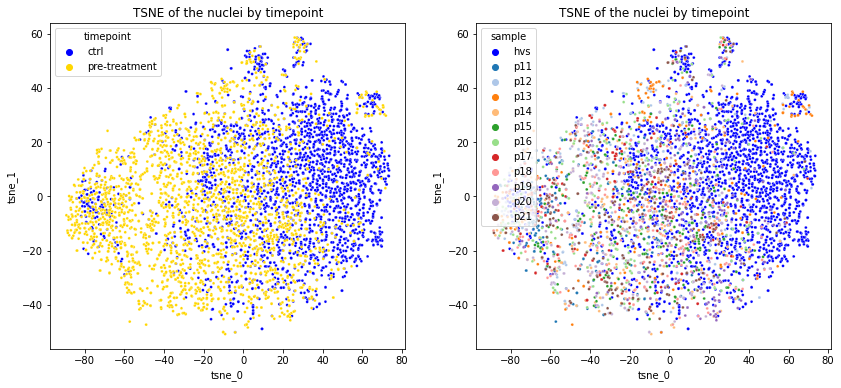

<IPython.core.display.Javascript object>

In [98]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "pre-treatment"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
color_dict = {"ctrl": "blue", "pre-treatment": "gold"}
ax[0] = sns.scatterplot(
    data=tmp_embs,
    x="tsne_0",
    y="tsne_1",
    hue="timepoint",
    ax=ax[0],
    palette=color_dict,
    s=8,
)

ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs["timepoint"] == "ctrl"), "sample"] = "hvs"
color_dict = {"hvs": "blue"}
ax[1] = sns.scatterplot(
    data=tmp_embs.loc[tmp_embs.loc[:, "sample"] == "hvs"],
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    ax=ax[1],
    palette=color_dict,
    s=8,
)
ax[1] = sns.scatterplot(
    data=tmp_embs.loc[tmp_embs.loc[:, "sample"] != "hvs"],
    x="tsne_0",
    y="tsne_1",
    hue="sample",
    ax=ax[1],
    palette="tab20",
    s=8,
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

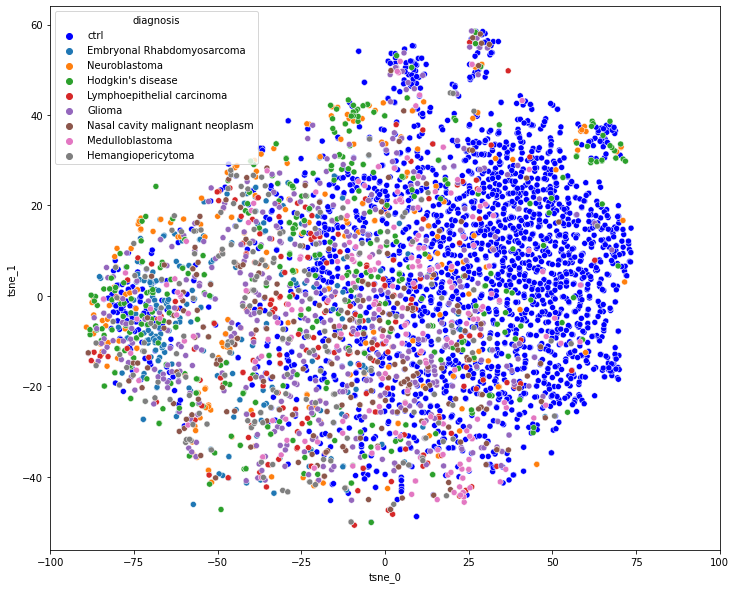

<IPython.core.display.Javascript object>

In [96]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "pre-treatment"])]
fig, ax = plt.subplots(figsize=[12, 10])
color_dict = {"ctrl": "blue"}
ax = sns.scatterplot(
    data=tmp_embs.loc[tmp_embs.loc[:, "diagnosis"] == "ctrl"],
    x="tsne_0",
    y="tsne_1",
    hue="diagnosis",
    ax=ax,
    palette=color_dict,
)
ax.set_xlim([-100, 100])
ax = sns.scatterplot(
    data=tmp_embs.loc[tmp_embs.loc[:, "diagnosis"] != "ctrl"],
    x="tsne_0",
    y="tsne_1",
    hue="diagnosis",
    ax=ax,
    palette="tab10",
)

---

## 4. Separability of the time points

Next, we will look more into the differences of the PBMC phenotypes at the different time points of the treatment in comparison to the healthy controls. To this end, we will train a RandomForest classifier model on distinguishing between the different data conditions.

To this end, we perform a 10-fold Stratified cross-validation approach and look at the average confusion matrix of the individual folds.

In [91]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc, n_folds=5, features=features_sc, labels=tp_labels
)

<IPython.core.display.Javascript object>

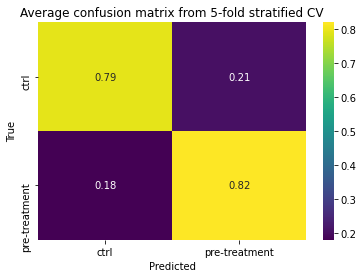

<IPython.core.display.Javascript object>

In [92]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(5))
plt.show()

The confusion matrix further emphasizes the previous statements. We see that overall each time point is relatively distinct from the other and from the negative control. However, for the later time points (intermediate and post-treatment) the phenotypes of the models become more heterogenous some showing features more similar to the healthy control especially for the intermediate time point that is visible. Whereas, for the later we see a relative uniform distribution of the predicted classes for the missclassified samples.

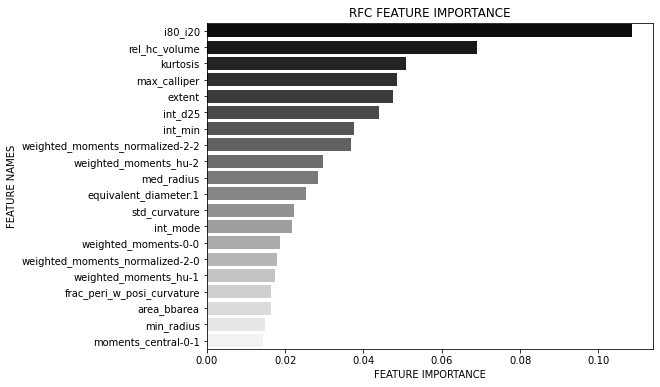

<IPython.core.display.Javascript object>

In [93]:
rfc = rfc.fit(features_sc, tp_labels)
plot_feature_importance(rfc.feature_importances_, features_sc.columns, "RFC ")

When we look at the features that got the highest importance we see that many of these are related to intensity features of the protein and 2D projected DAPI channel. Additionally some structural features like the equivalent diameter and the curvature are changing.

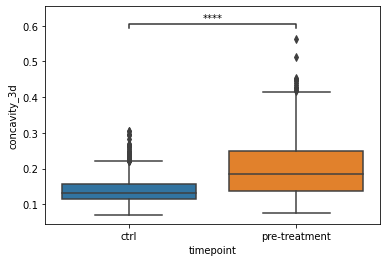

<IPython.core.display.Javascript object>

In [105]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="timepoint", y="concavity_3d", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="concavity_3d",
    box_pairs=[
        ("ctrl", "pre-treatment"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="timepoint", y="area", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="area",
    box_pairs=[
        ("ctrl", "1"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.boxplot(data=data, x="timepoint", y="concavity_3d", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="concavity_3d",
    box_pairs=[
        ("ctrl", "1"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[6, 6])
sns.boxplot(data=data, x="timepoint", y="rel_gh2ax_3d_int", ax=ax)
ax.set_ylim([0, 20000])
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="rel_gh2ax_3d_int",
    box_pairs=[
        ("ctrl", "1"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylim([0, 4000])
sns.boxplot(data=data, x="timepoint", y="rel_lamin_3d_int", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="rel_lamin_3d_int",
    box_pairs=[
        ("ctrl", "1"),
    ],
    test="Mann-Whitney",
    loc="outside",
    verbose=0,
)
plt.show()